# Equirectangular (360°) → Perspective View with RPY Rotations

This notebook loads an equirectangular panorama (JPG), applies roll–pitch–yaw rotations
using the convention **roll about +z**, **pitch about +x**, **yaw about +y** (applied in RPY order),
and renders a perspective view with a specified field of view (FOV).


In [129]:
import numpy as np
from PIL import Image
import math
import matplotlib.pyplot as plt
from pathlib import Path


## Configuration
- Set `IMAGE_PATH` to your input JPG.
- Adjust RPY angles, FOV, and output size as needed.

In [130]:
IMAGE_PATH = "goldwin_smith.jpg"  # <-- change to your image path

# Rotation parameters (degrees)
ROLL_DEG  = 25   # roll about +z
PITCH_DEG = 10  # pitch about +x
YAW_DEG   = 30  # yaw about +y

# Perspective view parameters
FOV_DEG = 90.0      # square FOV, horizontal == vertical
OUT_W   = 640
OUT_H   = 640

# Output path
OUTPUT_PATH = "./perspective.jpg"

## Angle ↔ Pixel mappings
We use the equirectangular parameterization:
\(\lambda(u) = 2\pi\,u/W - \pi\),\quad
\(\phi(v) = \tfrac{\pi}{2} - \pi\,v/H\).

In [131]:
def uv_to_lambda_phi(u, v, W, H):
    """Vectorized mapping from pixel coords (u,v) to angles (lambda, phi).
    u in [0, W), v in [0, H)
    lambda in [-π, π), phi in [-π/2, π/2]
    """
    lam = 2 * math.pi * (u / W) - math.pi
    phi = (math.pi / 2.0) - math.pi * (v / H)
    return lam, phi

def lambda_phi_to_uv(lam, phi, W, H):
    """Inverse mapping S^{-1}: angles to pixel coords (u,v)."""
    u = W * (lam + math.pi) / (2 * math.pi)
    v = H * ((math.pi / 2.0) - phi) / math.pi
    return u, v


## Rotations (RPY)
Rotation order: **roll → pitch → yaw**. We construct
\(R = R_y(\text{yaw})\, R_x(\text{pitch})\, R_z(\text{roll})\).
Roll about +z (tilt), Pitch about +x (up/down), Yaw about +y (left/right).

In [ ]:
def R_roll_z(deg):
    r = math.radians(deg)
    c, s = math.cos(r), math.sin(r)
    return np.array([[ c, -s, 0],
                     [ s,  c, 0],
                     [ 0,  0, 1]], dtype=np.float64)

def R_pitch_x(deg):
    r = math.radians(deg)
    c, s = math.cos(r), math.sin(r)
    return np.array([[1, 0, 0],
                     [0, c, s],
                     [0, -s, c]], dtype=np.float64)

def R_yaw_y(deg):
    r = math.radians(deg)
    c, s = math.cos(r), math.sin(r)
    return np.array([[ c, 0, -s],
                     [ 0, 1, 0],
                     [ s, 0, c]], dtype=np.float64)


## Spherical ↔ Cartesian
Axis convention: **x right**, **y up**, **z forward**.

\[x=\cos\phi\cos\lambda,\; y=\sin\phi,\; z=\cos\phi\sin\lambda\]
\[\phi=\arcsin(y),\; \lambda=\operatorname{atan2}(z,x)\]

In [133]:
def angles_to_unitvec(lam, phi):
    x = np.cos(phi) * np.sin(lam)
    y = np.sin(phi)
    z = np.cos(phi) * np.cos(lam)
    return x, y, z

def unitvec_to_angles(x, y, z):
    phi = np.arcsin(y)
    lam = np.arctan2(x, z)
    return lam, phi


## Rendering function
Creates a perspective image by sampling a square FOV in camera angles, rotating into world coordinates, and bilinearly sampling the panorama.

In [134]:
def render_perspective(equirect_rgb, roll_deg=25, pitch_deg=10, yaw_deg=30,
                       fov_deg=90, OUT_W=640, OUT_H=640):
       H, W = equirect_rgb.shape[:2]

       # Camera sampling angles (square window):
       fov = math.radians(fov_deg)
       lam_c = np.linspace(-fov/2, fov/2, OUT_W, dtype=np.float64)
       phi_c = np.linspace(-fov/2, fov/2, OUT_H, dtype=np.float64)
       lam_c_grid, phi_c_grid = np.meshgrid(lam_c, phi_c)

       # Camera unit rays
       x_c, y_c, z_c = angles_to_unitvec(lam_c_grid, phi_c_grid)
       print(x_c.shape, y_c.shape, z_c.shape)

       # Rotate camera -> world (inverse of world->camera)
       R = R_yaw_y(yaw_deg) @ R_pitch_x(pitch_deg) @ R_roll_z(roll_deg)
       vc = np.stack([x_c, y_c, z_c], axis=-1) # (H, W, 3)
       print(vc.shape)
       print(R.shape)
       vw = vc @ R  # (H, W, 3) #right multiplication = left multiplication by transpose = inverse for rotation

       x_w = vw[..., 0]
       y_w = vw[..., 1]
       z_w = vw[..., 2]
       lam_w, phi_w = unitvec_to_angles(x_w, y_w, z_w)

       # Map to panorama pixels (float coords)
       u_w = W * (lam_w + math.pi) / (2 * math.pi)
       v_w = H * ((math.pi / 2.0) - phi_w) / math.pi
       # convert to int for indexing
       u = np.floor(u_w).astype(np.int32) % W
       v = np.floor(v_w).astype(np.int32) % H
       v = H - 1 - v  # flip vertically for image coords
       out = equirect_rgb[v, u, :]
       return np.clip(out, 0.0, 1.0)

## Run: load image, render, display, save

(640, 640) (640, 640) (640, 640)
(640, 640, 3)
(3, 3)


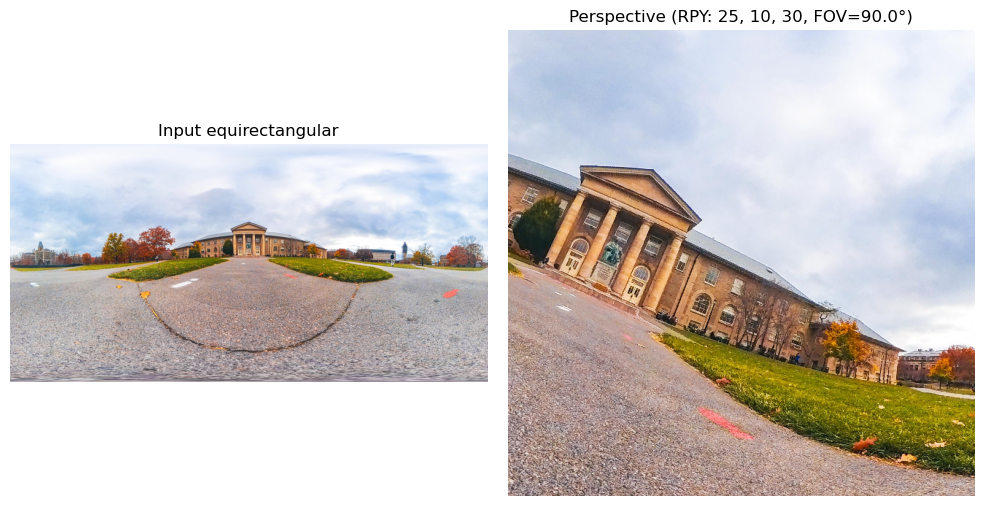

Saved perspective image to: ./perspective.jpg


In [135]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

try:
    img = Image.open(IMAGE_PATH).convert("RGB")
except FileNotFoundError:
    # Fallback: create a synthetic panorama if not found
    W_test, H_test = 720, 360
    arr = np.zeros((H_test, W_test, 3), dtype=np.uint8)
    for y in range(H_test):
        for x in range(W_test):
            arr[y, x, 0] = int(255 * x / (W_test - 1))
            arr[y, x, 1] = int(255 * (1 - y / (H_test - 1)))
            arr[y, x, 2] = 128 if (x // 20) % 2 == 0 else 40
    img = Image.fromarray(arr, mode="RGB")

img_np = np.asarray(img).astype(np.float32) / 255.0

persp = render_perspective(img_np,
                           roll_deg=ROLL_DEG,
                           pitch_deg=PITCH_DEG,
                           yaw_deg=YAW_DEG,
                           fov_deg=FOV_DEG,
                           OUT_W=OUT_W,
                           OUT_H=OUT_H)

out_img = Image.fromarray((persp * 255).astype(np.uint8))
out_img.save(OUTPUT_PATH)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(img_np)
axes[0].set_title("Input equirectangular")
axes[0].axis("off")
axes[1].imshow(persp)
axes[1].set_title(f"Perspective (RPY: {ROLL_DEG}, {PITCH_DEG}, {YAW_DEG}, FOV={FOV_DEG}°)")
axes[1].axis("off")
plt.tight_layout()
plt.show()
print(f"Saved perspective image to: {OUTPUT_PATH}")